In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import numpy as np

from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn import set_config; set_config(display='diagram')

# PCA exploration

## Load dataset

__Lets load a face image dataset and apply PCA.__

In [7]:
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

image shape : (50, 37)
image target : 3 - George W Bush


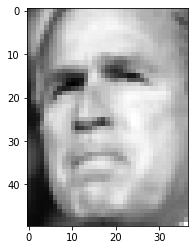

In [16]:
plt.imshow(faces['images'][12],cmap=plt.cm.gray)
print(f"image shape : {faces['images'][12].shape}")
print(f"image target : {faces['target'][12]} - {faces['target_names'][faces['target'][12]]}")
plt.show()  

## Let’s visualize some faces.

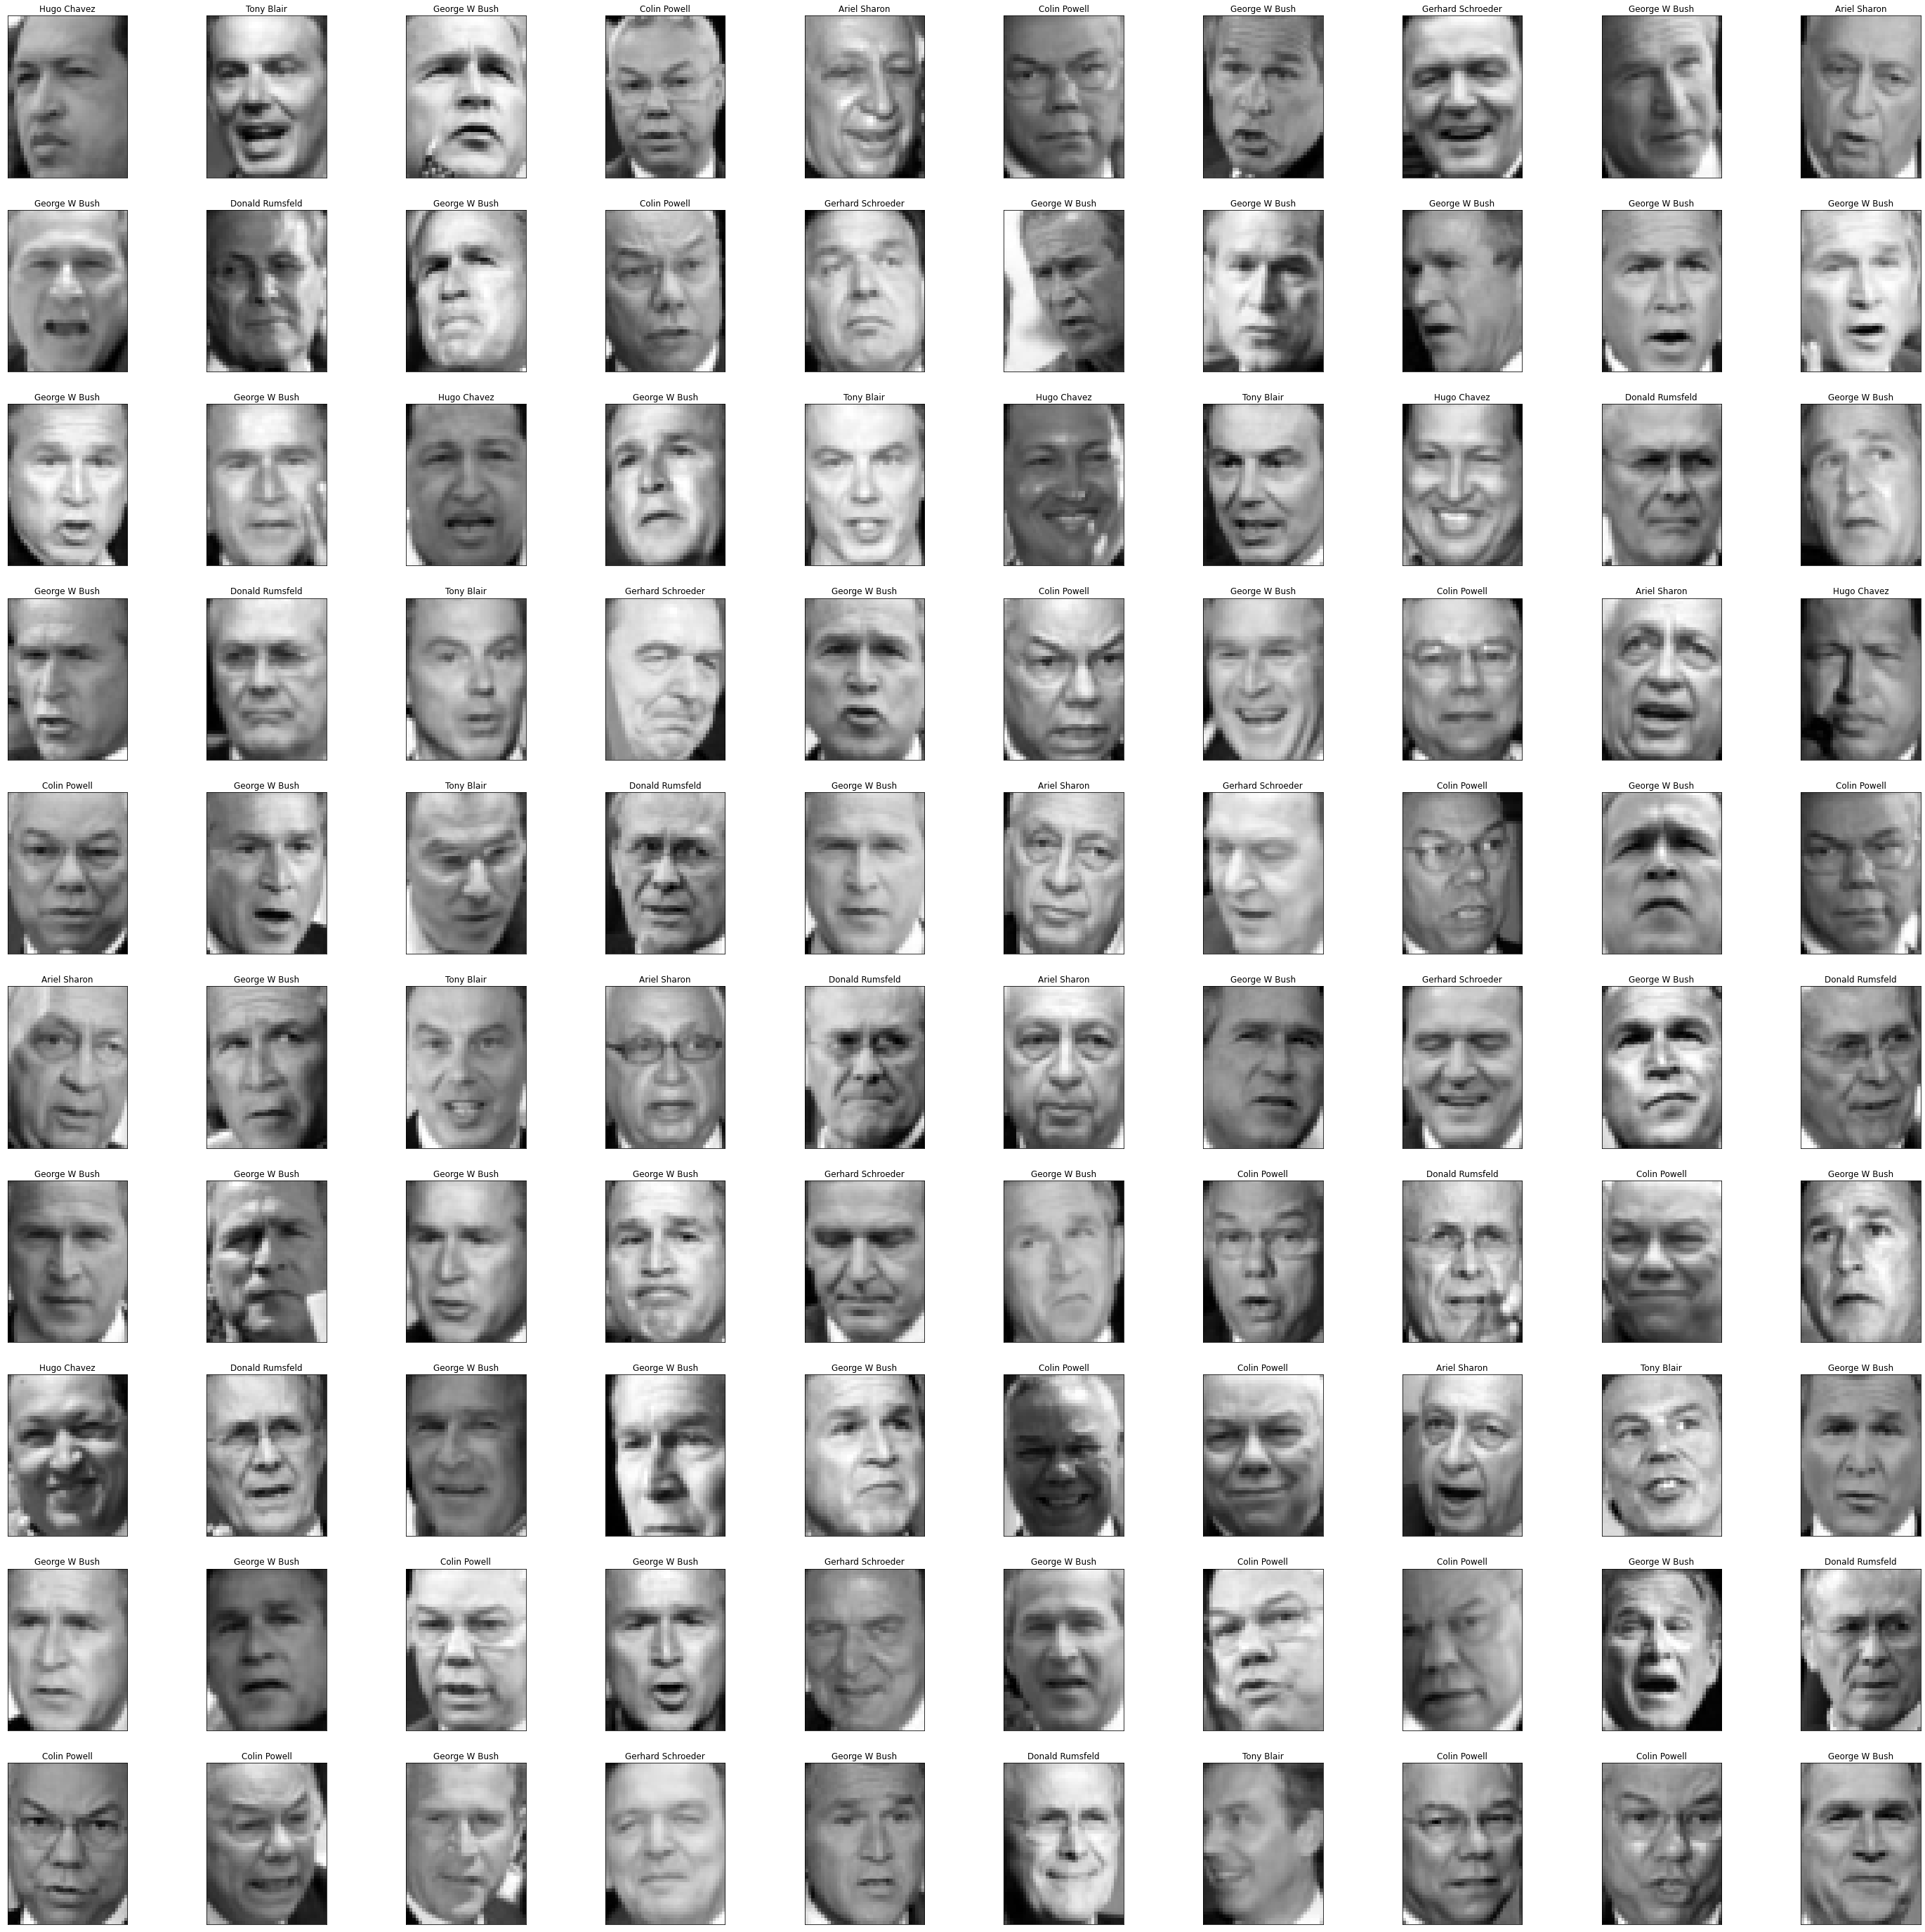

In [28]:
fig = plt.figure(figsize=(50,50))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.title(faces.target_names[faces.target[i]], size=12)
    plt.imshow(faces.images[i], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

## Compress images with PCA

In [29]:
X = faces['data']
X.shape

pca = PCA(n_components=150)
pca.fit(X)
data_projected = pca.transform(X)
data_projected.shape

data_reconstructed = pca.inverse_transform(data_projected)
data_reconstructed_reshaped = np.reshape(data_reconstructed,(1288, 50, 37))

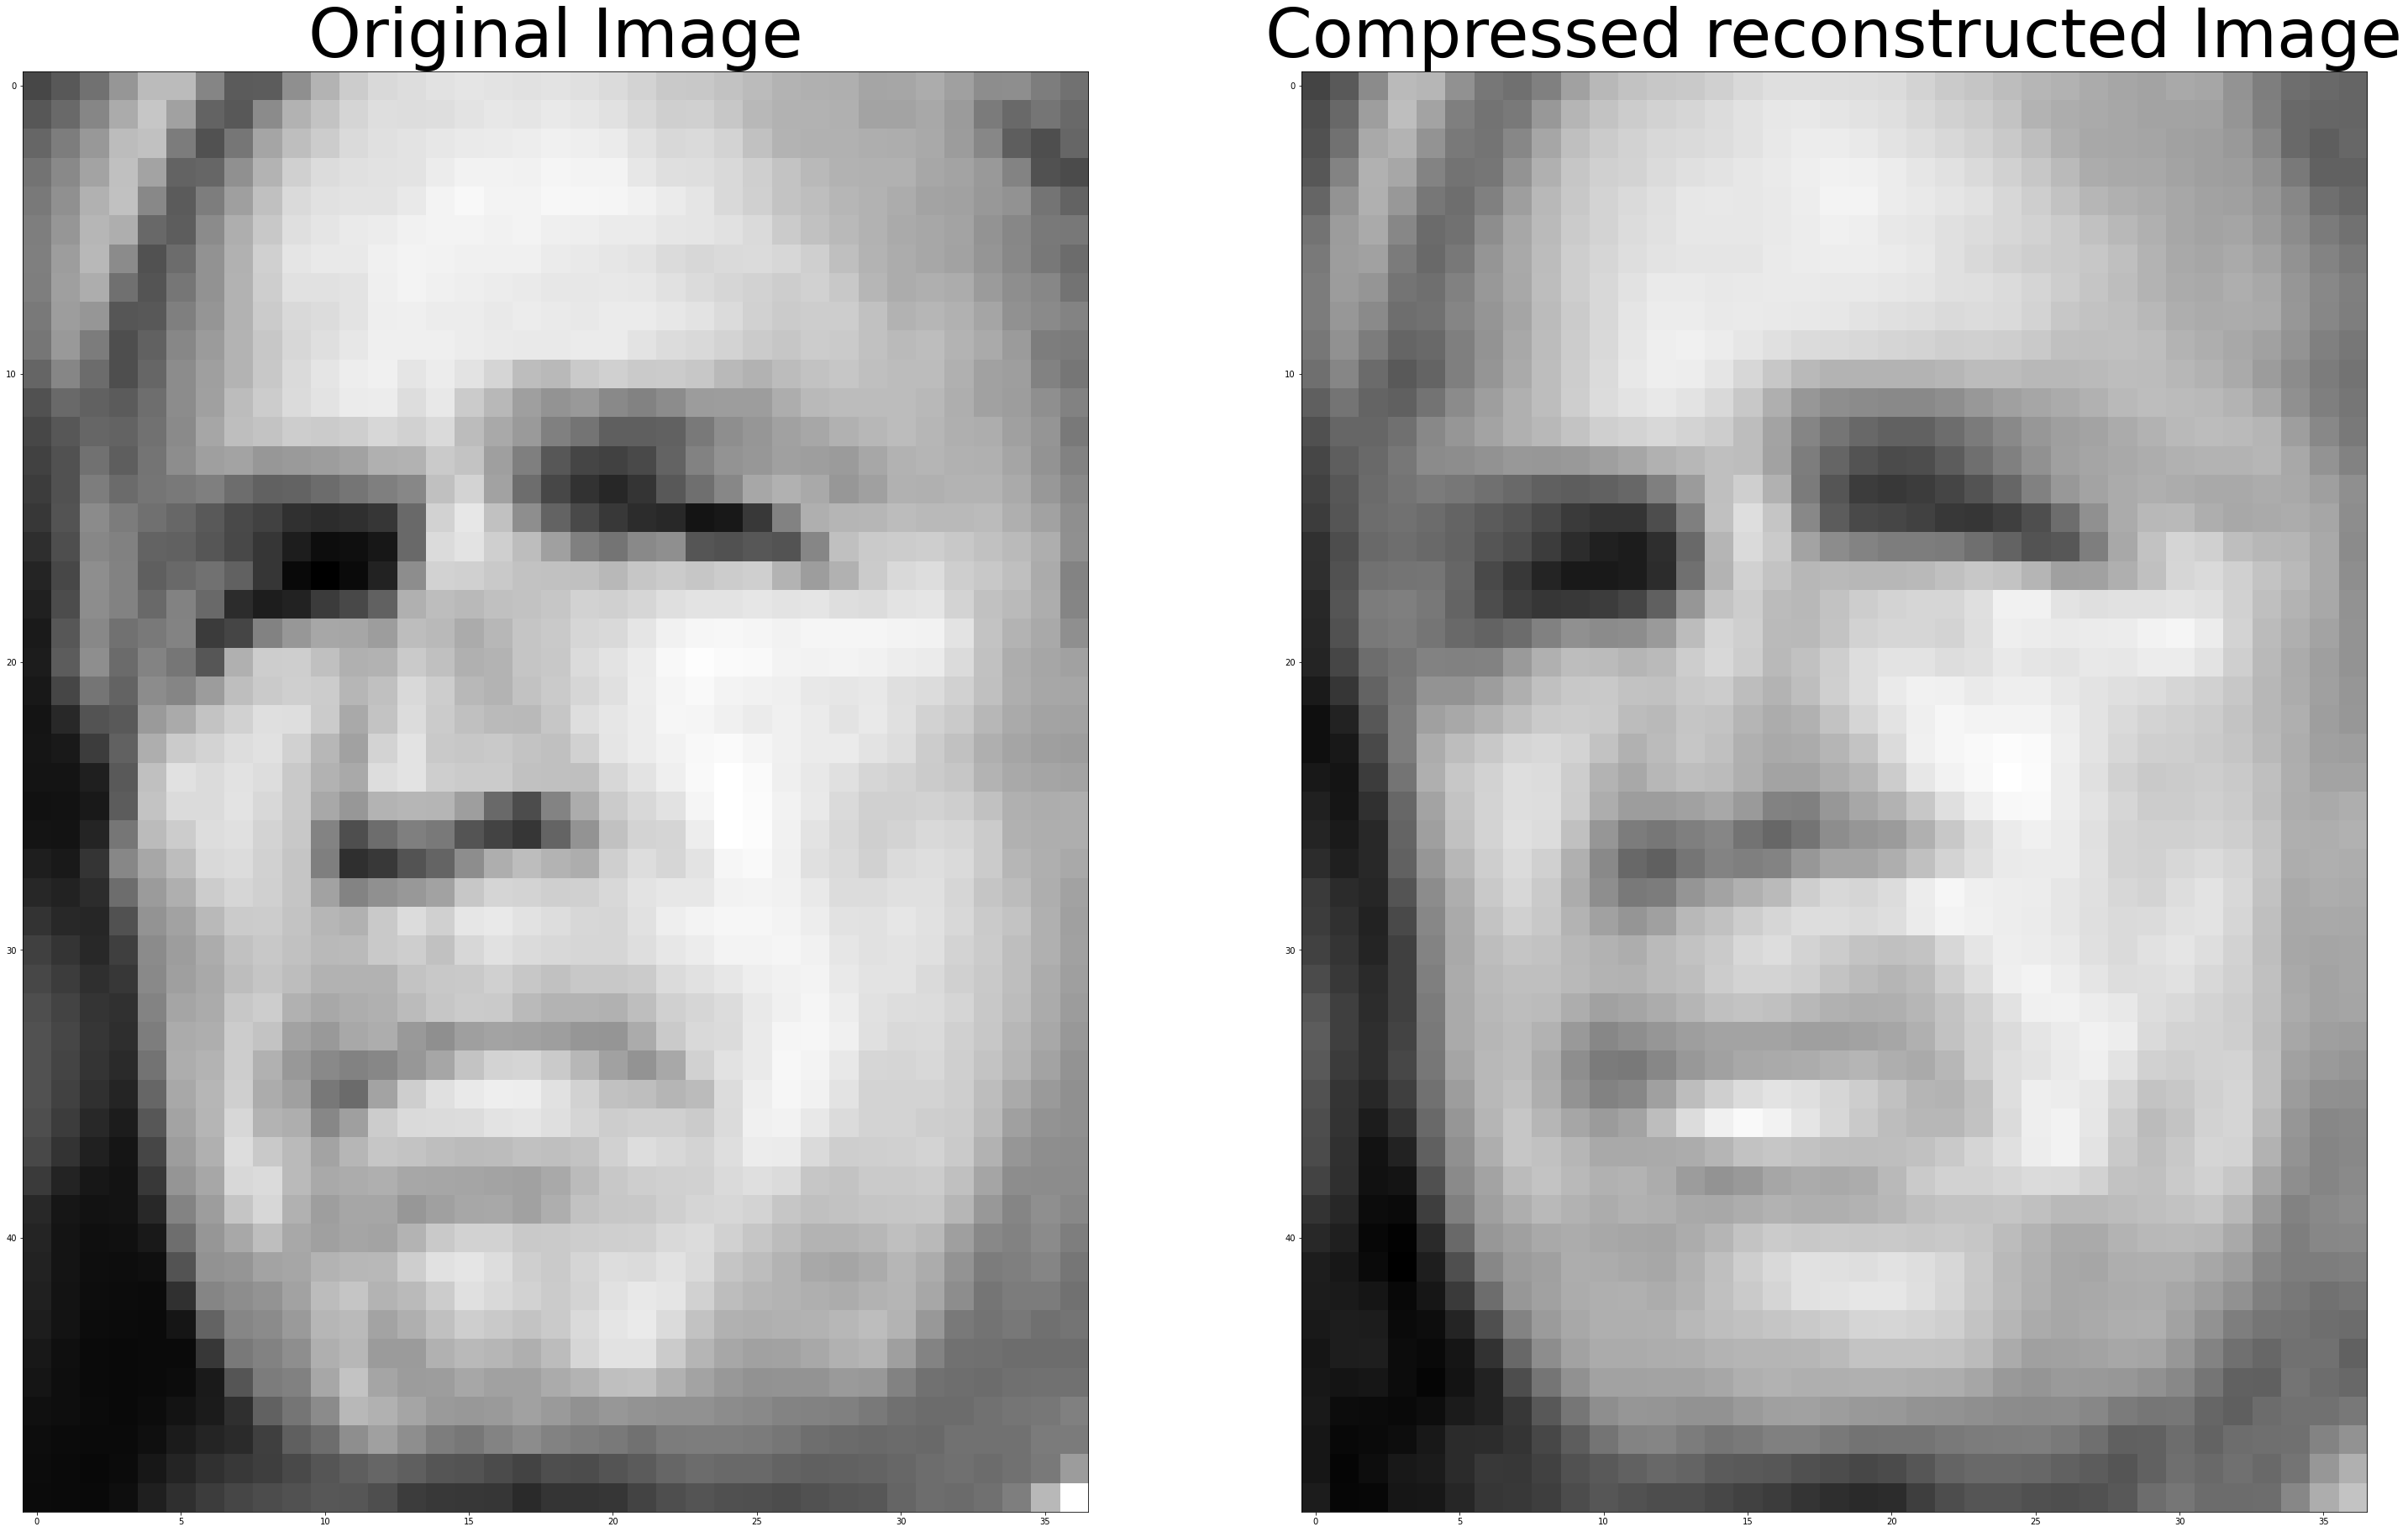

In [39]:
fig = plt.figure(figsize=(50,50))

plt.subplot(1, 2, 1)
plt.title('Original Image', size=80)
plt.imshow(faces.images[12], cmap=plt.cm.gray)

plt.subplot(1, 2, 2)
plt.title('Compressed reconstructed Image', size=80)
plt.imshow(data_reconstructed_reshaped[12],cmap=plt.cm.gray)

plt.show()

### Image-Plot of the **5 first** principal components.

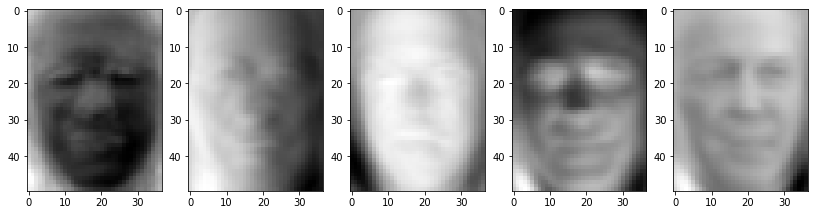

In [47]:
fig = plt.figure(figsize=(14,20))
for i in range(5):
    plt.subplot(1, 5, i+1)
    tmp = np.reshape(pca.components_[i],(50, 37))
    plt.imshow(tmp,cmap=plt.cm.gray)

### Image-Plot of the **last** principal components.

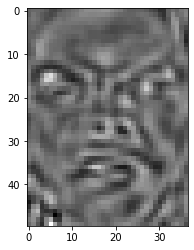

In [48]:
plt.imshow(np.reshape(pca.components_[149],(50, 37)),cmap=plt.cm.gray)


## Choose the Number of Components

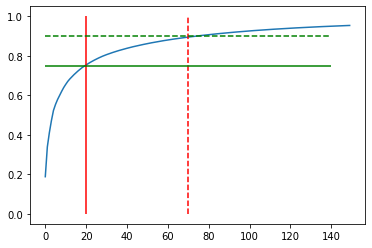

In [50]:
cumulative_sum_explained_variance = []
sum = 0
for i in pca.explained_variance_ratio_:
    sum = sum + i
    cumulative_sum_explained_variance.append(sum)
plt.plot(cumulative_sum_explained_variance)
plt.vlines(x=20,ymin=0,ymax=1,colors='r')
plt.vlines(x=70,ymin=0,ymax=1,colors='r',linestyles='--')
plt.hlines(y=0.75,xmin=0,xmax=140,colors='g')
plt.hlines(y=0.9,xmin=0,xmax=140,colors='g',linestyles='--')
plt.show()

- The first 20 components contain more than 75% of the variance
- The first 70 components describe 90% of the variance

__Let's kepp the first 30 components__

# Model exploration

## Train test split the face dataset

In [55]:
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

X = faces['data']
y = faces['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Transform the training / test set to reduce the number of dimensions / features

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=210)
pca.fit(X_train)
X_train_projected = pca.transform(X_train)

In [60]:
X_test_projected = pca.transform(X_test)

## Cross validate the choice of best hyperparameters for the Support Vector Classification (SVC)

In [62]:
svc = SVC()

param_grid = {'kernel':['poly', 'linear', 'rbf', 'sigmoid'], 
              'C':[0.0001, 0.001,0.01,1, 10], 
              'gamma' :[ 0.000001, 0.00001, 0.0001]}

# svc.fit(X_train_projected,y_train)
# svc.score(X_train_projected,y_train)

grd_s = GridSearchCV(svc,param_grid,scoring='f1_weighted',n_jobs=-1,cv=5)

grd_s.fit(X_train_projected,y_train)

grd_s.best_params_

{'C': 0.0001, 'gamma': 1e-06, 'kernel': 'linear'}

In [63]:
svc_tuned = SVC(kernel='linear',C=10,gamma=1)
svc_tuned.fit(X_train_projected,y_train)
y_pred = svc_tuned.predict(X_test_projected)

In [66]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65        39
           1       0.74      0.86      0.79       111
           2       0.74      0.71      0.73        63
           3       0.89      0.85      0.87       276
           4       0.63      0.79      0.70        47
           5       0.82      0.62      0.71        37
           6       0.80      0.69      0.74        71

    accuracy                           0.79       644
   macro avg       0.75      0.74      0.74       644
weighted avg       0.80      0.79      0.79       644



# Model construction

How many components give the best score?

In [75]:
grid_search = GridSearchCV(
    my_pip, 
    param_grid={'pca__n_components': [250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265]},
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

{'pca__n_components': 264}

In [76]:
my_pip = Pipeline([('pca', PCA(n_components=264)),
                    ('svc', SVC(kernel='linear',C=10,gamma=1)),])

my_pip

Pipeline(steps=[('pca', PCA(n_components=264)),
                ('svc', SVC(C=10, gamma=1, kernel='linear'))])

In [77]:
my_pip.fit(X_train,y_train)
y_pred = my_pip.predict(X_test)

In [78]:
my_pip.fit(X_train,y_train)
y_pred = my_pip.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        39
           1       0.75      0.85      0.79       111
           2       0.72      0.68      0.70        63
           3       0.88      0.86      0.87       276
           4       0.61      0.74      0.67        47
           5       0.79      0.62      0.70        37
           6       0.78      0.69      0.73        71

    accuracy                           0.79       644
   macro avg       0.74      0.74      0.74       644
weighted avg       0.79      0.79      0.79       644



# 65% to 88% precision